## Imports and git cloning

In [1]:
%pylab inline --no-import-all

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9")

# Create the path to save submission files
SUBMISSION_PATH = Path("./submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)

# Clone the GitHub repository
# !rm -rf GLC
# !git clone https://github.com/maximiliense/GLC
    
    
# For evaluation and submission
from GLC.metrics import top_30_error_rate, top_k_error_rate_from_sets, predict_top_30_set
from GLC.submission import generate_submission_file

# For data loading and visualization
from GLC.data_loading.common import load_patch
from GLC.plotting import visualize_observation_patch
from GLC.data_loading.environmental_raster import PatchExtractor



Populating the interactive namespace from numpy and matplotlib


## Data loading, metadata and visualization

Import and display head

In [2]:
# Load train set of observations from France and USA and merge
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")
df_obs = pd.concat((df_obs_fr, df_obs_us))

# Extract training and validation subsets as np arrays
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

# Separate values to predict
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

# Validation proportion
n_val = len(obs_id_val)
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))


# Same with test set of observations
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")
df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

# Extract observaions as np array
obs_id_test = df_obs_test.index.values

# Test set size
print("Number of observations for testing: {}".format(len(df_obs_test)))

# Display head of the df
print("Train df shape: ", df_obs.shape)
display(df_obs.head(3))
print("Test df shape: ", df_obs_test.shape)
display(df_obs_test.head(3))

Validation set size: 40080 (2.5% of train observations)
Number of observations for testing: 36421
Train df shape:  (1627475, 4)


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train


Test df shape:  (36421, 2)


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459


## EDA

We notice that the dataset is unbalanced for the species id, so we might have to perform data augmentation or filtering to reduce this gap

Total number of species: 17037


(1, 6701.000000000001)

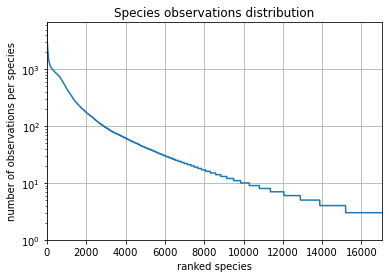

In [4]:
species_value_counts = df_obs["species_id"].value_counts()

print("Total number of species: {}".format(len(species_value_counts)))


fig = plt.figure()
ax = fig.gca()

x = np.arange(len(species_value_counts))
ax.plot(x, species_value_counts)

ax.set_yscale("log")

ax.set_xlabel("ranked species")
ax.set_ylabel("number of observations per species")
ax.set_title("Species observations distribution")

ax.grid()
ax.autoscale(tight=True)
ax.set_ylim(bottom=1)

Some metadata for the species may be interesting, especially the plantae/animalia kingdom label:

In [5]:
df_species = pd.read_csv(DATA_PATH / "metadata" / "species_details.csv", sep=";")

print("Total number of species: {}".format(len(df_species)))

print("\nNumber of species in each kingdom:")
print(df_species.GBIF_kingdom_name.value_counts())

df_species.head()

Total number of species: 17037

Number of species in each kingdom:
Plantae     9080
Animalia    7957
Name: GBIF_kingdom_name, dtype: int64


,species_id,GBIF_species_id,GBIF_species_name,GBIF_genus_name,GBIF_family_name,GBIF_kingdom_name
0,0,5356345,Laburnum anagyroides,Laburnum,Fabaceae,Plantae
1,1,2874515,Cucurbita maxima,Cucurbita,Cucurbitaceae,Plantae
2,2,2874569,Cucumis sativus,Cucumis,Cucurbitaceae,Plantae
3,3,3033363,Ranunculus acris,Ranunculus,Ranunculaceae,Plantae
4,4,3034830,Heracleum sphondylium,Heracleum,Apiaceae,Plantae


Metadata of the environmental rasters and of the landcover data may give some additional information for interpretation. At this point, I'm not sure of the difference between landcover and suggested landcover alignment.

In [3]:
df_env_vars = pd.read_csv(DATA_PATH / "metadata" / "environmental_variables.csv", sep=";")
display(df_env_vars.head())

df_landcover_labels = pd.read_csv(DATA_PATH / "metadata" / "landcover_original_labels.csv", sep=";")
display(df_landcover_labels.head())

df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
display(df_suggested_landcover_alignment.head())

,name,description,resolution
0,bio_1,Annual Mean Temperature,30 arcsec
1,bio_2,Mean Diurnal Range (Mean of monthly (max temp ...,30 arcsec
2,bio_3,Isothermality (bio_2/bio_7) (* 100),30 arcsec
3,bio_4,Temperature Seasonality (standard deviation * ...,30 arcsec
4,bio_5,Max Temperature of Warmest Month,30 arcsec


,landcover_code,original_landcover_code,landcover_label
0,0,0,Missing Data
1,1,11,Annual Summer Crops
2,2,12,Annual Winter Crops
3,3,31,Broad-leaved Forests
4,4,32,Coniferous Forests


,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


### Patches
The patches consist of images centered at each observation's location capturing three types of information in the 250m x 250m neighboring square:
* remote sensing imagery under the form of RGB-IR images
* land cover data
* altitude data

They are located in the two subfolder patches-fr and patches-us, one for each country. **See the original notebook for full information about the git folders and data repartition.**


There are 4 files for each observation:

* a color JPEG image containing an RGB image (*_rgb.jpg)
* a grayscale JPEG image containing a near-infrared image (*_near_ir.jpg)
* a TIFF with Deflate compression containing altitude data (*_altitude.tif)
* a TIFF with Deflate compression containing land cover data (*_landcover.tif)

_The git provides a loading function which, given an observation id, loads all this data at once using Pillow for the images and tiffile for the TIFF files and returns them as a tuple (rgb, near-ir, altitude, landcover)_

In [28]:
# Syntax to extract a patch:
patch = load_patch(10171444, DATA_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

# If wanted, perform automatically the landcover alignment during extraction:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
patch = load_patch(10171444, DATA_PATH, landcover_mapping=landcover_mapping)

# Extracts land cover labels
landcover_labels = df_suggested_landcover_alignment[["suggested_landcover_code", "suggested_landcover_label"]].drop_duplicates().sort_values("suggested_landcover_code")["suggested_landcover_label"].values

visualize_observation_patch(patch, observation_data=df_obs.loc[10561900], landcover_labels=landcover_labels)

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000275511A1C80> (for post_execute):


AttributeError: 'LineCollection' object has no property 'dms'

AttributeError: 'LineCollection' object has no property 'dms'

<Figure size 1080x720 with 5 Axes>

### Environmental rasters
The rasters contain low-resolution environmental data - bioclimatic and pedological data.

There are two ways to use this data:
1. directly use the environmental vectors pre-extracted that can be found in the CSV file pre-extracted/environmental_vectors.csv
2. manually extract patches centered at each observation using the rasters located in the rasters subfolder

**Environmental vectors:**

In [3]:
df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")
print(df_env.shape)
display(df_env.head())

print("Variables which can contain NaN values:")
display(df_env.isna().any())

(1663896, 27)


C:\Users\chiro\.conda\envs\SONDRA\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,...,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,...,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,...,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,...,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,...,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0


Variables which can contain NaN values:


bio_1     True
bio_2     True
bio_3     True
bio_4     True
bio_5     True
bio_6     True
bio_7     True
bio_8     True
bio_9     True
bio_10    True
bio_11    True
bio_12    True
bio_13    True
bio_14    True
bio_15    True
bio_16    True
bio_17    True
bio_18    True
bio_19    True
bdticm    True
bldfie    True
cecsol    True
clyppt    True
orcdrc    True
phihox    True
sltppt    True
sndppt    True
dtype: bool

**Environmental rasters:**

The function uses rasterio.

The following code loads the rasters for all the variables and prepares to extract patches of size 256x256.

Here the patches are not of the same resolution as the provided ones as one pixel corresponds to 30arcsec (about 1km) for the bioclimatic data and to 250m for the pedologic data.
Note that this uses quite a lot of memory (~18Go) as all the rasters will be loaded in the RAM.
To avoid this issue, we will only load the bioclimatic rasters here.

Number of rasters: 19
Patch shape: (19, 256, 256)
Data type: float32
Contains NaN: True


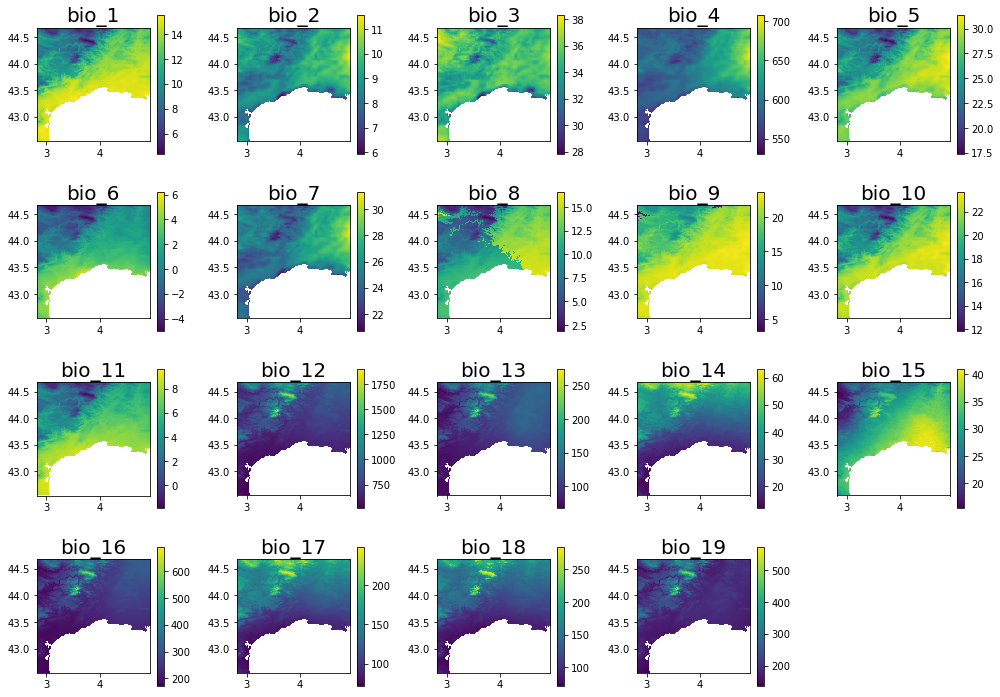

In [30]:
extractor = PatchExtractor(DATA_PATH / "rasters", size=256)
extractor.add_all_bioclimatic_rasters()

print("Number of rasters: {}".format(len(extractor)))

# To add all the rasters (18Gb RAM required!!)
# extractor.add_all_rasters()

# To load pedologic rasters
# extractor.add_all_pedologic_rasters()


# To extract a patch at a given location
patch = extractor[43.61, 3.88]

print("Patch shape: {}".format(patch.shape))
print("Data type: {}".format(patch.dtype))


# The patch may contain nan values due to sea and rivers for instance
print("Contains NaN: {}".format(np.isnan(patch).any()))


# This provided function helps plotting the environmental rasters
fig = plt.figure(figsize=(14, 10))
extractor.plot((43.61, 3.88), fig=fig)

 # Baselines

How to generate a submission (here always predicting the first 30 species on each observation):

In [31]:
first_30_species = np.arange(30)
s_pred = np.tile(first_30_species[None], (len(df_obs_test), 1))
print(s_pred.shape)
generate_submission_file(SUBMISSION_PATH / "30_first_species_submission.csv", df_obs_test.index, s_pred)


(36421, 30)


**Constant baseline:**

Always predicting the 30 most present species in the observations

In [32]:
# Find the 30 most present species
species_distribution = df_obs.loc[obs_id_train]["species_id"].value_counts(normalize=True)
top_30_most_observed = species_distribution.index.values[:30]

# Simulate a prediction with np.tile on the validation set
n_val = len(obs_id_val)
s_pred = np.tile(top_30_most_observed[None], (n_val, 1))
print("Validation set prediction shape: ", s_pred.shape)

# Compute the top_k_error_rate as a metrics of model accuracy
score = top_k_error_rate_from_sets(y_val, s_pred)
print("Top-30 error rate: {:.1%}".format(score))


# Then we do the same on the test set to generate a submission
# with this baseline
n_test = len(df_obs_test)
s_pred = np.tile(top_30_most_observed[None], (n_test, 1))
print("Test set prediction shape: ", s_pred.shape)

# Generate the submission file
generate_submission_file(SUBMISSION_PATH / "constant_top_30_most_present_species_baseline.csv", df_obs_test.index, s_pred)

Validation set prediction shape:  (40080, 30)
Top-30 error rate: 93.5%
Test set prediction shape:  (36421, 30)


**Random forest on environmental vector baseline:**

This baseline trains a random forest on the pre-generated environmental vectors data.

In [4]:
# RF parameters
n_estimators = 50
max_depth = 12

# Load the environmental vectors
df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")

# Define the train, val and test set as np arrays
X_train = df_env.loc[obs_id_train].values
X_val = df_env.loc[obs_id_val].values
X_test = df_env.loc[obs_id_test].values


# Call and imputer to deal with nan missing values
from sklearn.impute import SimpleImputer
imp = SimpleImputer(
    missing_values=np.nan,
    strategy="constant",
    fill_value=np.finfo(np.float32).min,
)

# Fit the imputer on the train set
print("***** Imputer started *****")
imp.fit(X_train)

# Apply the imputer to the sets
X_train = imp.transform(X_train)
X_val = imp.transform(X_val)
X_test = imp.transform(X_test)
print("***** Imputer successful *****\n")


# Call a RF classifier, fit it on trainin set
from sklearn.ensemble import RandomForestClassifier
est = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                             n_jobs=-1, verbose=0)


print("***** Fitting started *****")
est.fit(X_train, y_train)
print("***** Fitting successful *****\n")


# We define a batch predictor to take care of the memory
# as there are more than 17k classes
def batch_predict(predict_func, X, batch_size=2**11):
    res = predict_func(X[:1])
    n_samples, n_outputs, dtype = X.shape[0], res.shape[1], res.dtype
    
    preds = np.empty((n_samples, n_outputs), dtype=dtype)
    print(preds.shape)
    
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        preds[i:i+batch_size] = predict_func(X_batch)
            
    return preds


# We can finally compute the top 30 error rate on the val set
def predict_func(X):
    y_score = est.predict_proba(X)
    s_pred = predict_top_30_set(y_score)
    return s_pred

print("***** Batch predict started *****")
s_val = batch_predict(predict_func, X_val)
print("***** Batch predict successful *****\n")

score_val = top_k_error_rate_from_sets(y_val, s_val)
print("Top-30 error rate: {:.1%}".format(score_val))


# Compute baseline on the test set
print("***** Batch predict test started *****")
s_pred = batch_predict(predict_func, X_test)
print("***** Batch predict test successful *****\n")

# Generate the submission file
file = "./submissions/rf_env_vect_" + str(n_estimators)+ "_est_" + str(max_depth) + "_max_dp"+ str(round(100*score_val)) +"_score.csv"
generate_submission_file(file, df_obs_test.index, s_pred)

***** Imputer started *****
***** Imputer successful *****

***** Fitting started *****
***** Fitting successful *****

***** Batch predict started *****
(40080, 30)
***** Batch predict successful *****

Top-30 error rate: 79.0%
***** Batch predict test started *****
(36421, 30)
***** Batch predict test successful *****

